# Model Creation

In [8]:
import torch

from train import text_to_token_ids
from architecture import GPTModel
from train import train_model_simple, plot_losses, generate, text_to_token_ids, token_ids_to_text

GPT_CONFIG_124M = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 256,  # Context length
        "emb_dim": 768,          # Embedding dimension
        "n_heads": 12,           # Number of attention heads
        "n_layers": 12,          # Number of layers
        "drop_rate": 0.1,        # Dropout rate
        "qkv_bias": False        # Query-Key-Value bias
    }

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

model.eval()  # disable dropout


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [9]:
import tiktoken
from train import generate

start_context = "Hello, I am"

tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
print("\nInput text:", start_context)
print("Encoded input text:", encoded)
print("encoded_tensor.shape:", encoded_tensor.shape)

out = generate(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = tokenizer.decode(out.squeeze(0).tolist())

print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
print("\nOutput:", out)
print("Output length:", len(out[0]))
print("Output text:", decoded_text)


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991,
          6842, 37891, 19970, 47477]])
Output length: 14
Output text: Hello, I am Laur inhab DistrinetalkQueue bear confidentlyggyenium


# Model Training 

## Loading of data

In [13]:
import os


txt_file_path = "./../BookAndDataFiles/txtFile"

with open(os.path.join(txt_file_path, "book.txt"), "r", encoding="utf-8") as f:
    text_data = f.read()

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 3055720
Tokens: 936434


In [14]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [15]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from TextDataProcessing.data import create_dataloader_v1


batch_size = 2

train_loader = create_dataloader_v1(
    train_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [16]:
print(f'The total batch is {len(train_loader)}')

The total batch is 1609


## Model Training 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [24]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 6
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=100, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.209, Val loss 9.522
Ep 1 (Step 000100): Train loss 5.192, Val loss 6.112
Ep 1 (Step 000200): Train loss 5.028, Val loss 5.720
Ep 1 (Step 000300): Train loss 5.422, Val loss 5.611
Ep 1 (Step 000400): Train loss 4.651, Val loss 5.483
Ep 1 (Step 000500): Train loss 4.908, Val loss 5.506
Ep 1 (Step 000600): Train loss 4.614, Val loss 5.398
Ep 1 (Step 000700): Train loss 4.595, Val loss 5.395
Ep 1 (Step 000800): Train loss 4.618, Val loss 5.246
Ep 1 (Step 000900): Train loss 4.708, Val loss 5.215
Ep 1 (Step 001000): Train loss 4.819, Val loss 5.226
Ep 1 (Step 001100): Train loss 4.337, Val loss 5.212
Ep 1 (Step 001200): Train loss 4.432, Val loss 5.148
Ep 1 (Step 001300): Train loss 4.418, Val loss 5.154
Ep 1 (Step 001400): Train loss 4.389, Val loss 5.021
Ep 1 (Step 001500): Train loss 4.264, Val loss 5.069
Ep 1 (Step 001600): Train loss 4.315, Val loss 5.059
Every effort moves you, and  ‘I do not be  ’ said Gimli. ‘I will not be  ’  ‘I do not be  ’  ’  ’  

In [25]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [26]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

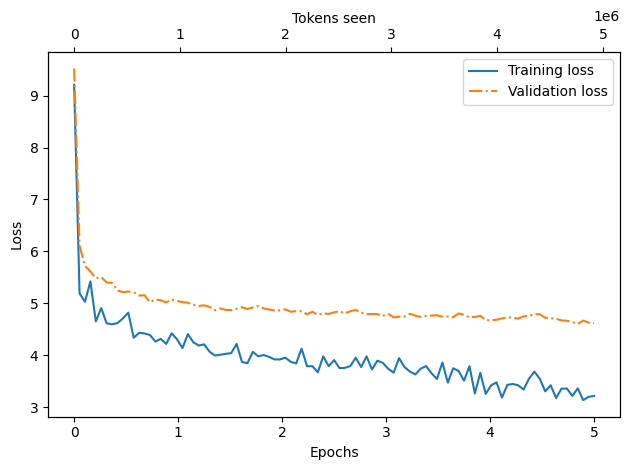

In [27]:
# epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
epochs_tensor = torch.linspace(0, 5, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Inference

In [28]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [29]:
start_context = "He is"
tokenizer = tiktoken.get_encoding("gpt2")
output = generate(model, idx = text_to_token_ids(start_context, tokenizer), max_new_tokens = 30, context_size=4, temperature=0.0, top_k=None, eos_id=None)
print(tokenizer.decode(output.squeeze(0).tolist()))

He is 
to the king. 
‘I have not yet.’ 
‘I have not yet.’ 



## Save and load

In [30]:
torch.save(model.state_dict(), "model.pth")

In [31]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [32]:
start_context = "He was"
tokenizer = tiktoken.get_encoding("gpt2")
output = generate(model, idx = text_to_token_ids(start_context, tokenizer), max_new_tokens = 30, context_size=4, temperature=0.0, top_k=None, eos_id=None)
print(tokenizer.decode(output.squeeze(0).tolist()))

He was 
and the king, and he had 
was in the king’s 
was in the king’s 
was
